In [73]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import PathPatch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.metrics import f1_score as f1
from sklearn.metrics import confusion_matrix
from sklearn.metrics import *

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import warnings
warnings.simplefilter(action='ignore', category= FutureWarning)






In [74]:
df_data = pd.read_csv('dataset_phishing.csv')
df_data.shape

(11430, 89)

In [75]:
df_data.head()

,url,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,http://www.crestonwood.com/router.php,37,19,0,3,0,0,0,0,0,...,0,1,0,45,-1,0,1,1,4,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,77,23,1,1,0,0,0,0,0,...,1,0,0,77,5767,0,0,1,2,phishing
2,https://support-appleld.com.secureupdate.duila...,126,50,1,4,1,0,1,2,0,...,1,0,0,14,4004,5828815,0,1,0,phishing
3,http://rgipt.ac.in,18,11,0,2,0,0,0,0,0,...,1,0,0,62,-1,107721,0,0,3,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,55,15,0,2,2,0,0,0,0,...,0,1,0,224,8175,8725,0,0,6,legitimate


In [76]:
df_data.columns

Index(['url', 'length_url', 'length_hostname', 'ip', 'nb_dots', 'nb_hyphens',
       'nb_at', 'nb_qm', 'nb_and', 'nb_or', 'nb_eq', 'nb_underscore',
       'nb_tilde', 'nb_percent', 'nb_slash', 'nb_star', 'nb_colon', 'nb_comma',
       'nb_semicolumn', 'nb_dollar', 'nb_space', 'nb_www', 'nb_com',
       'nb_dslash', 'http_in_path', 'https_token', 'ratio_digits_url',
       'ratio_digits_host', 'punycode', 'port', 'tld_in_path',
       'tld_in_subdomain', 'abnormal_subdomain', 'nb_subdomains',
       'prefix_suffix', 'random_domain', 'shortening_service',
       'path_extension', 'nb_redirection', 'nb_external_redirection',
       'length_words_raw', 'char_repeat', 'shortest_words_raw',
       'shortest_word_host', 'shortest_word_path', 'longest_words_raw',
       'longest_word_host', 'longest_word_path', 'avg_words_raw',
       'avg_word_host', 'avg_word_path', 'phish_hints', 'domain_in_brand',
       'brand_in_subdomain', 'brand_in_path', 'suspecious_tld',
       'statistical_report', 

In [77]:
df_data['target'] = pd.get_dummies(df_data.status)['legitimate'].astype('int')
df_data.drop('status',axis=1, inplace=True)
df_data[['url','target']].head(5)

,url,target
0,http://www.crestonwood.com/router.php,1
1,http://shadetreetechnology.com/V4/validation/a...,0
2,https://support-appleld.com.secureupdate.duila...,0
3,http://rgipt.ac.in,1
4,http://www.iracing.com/tracks/gateway-motorspo...,1


In [78]:
tmp = df_data.isnull().sum().reset_index(name='missing_val')
tmp[tmp.missing_val !=0]


,index,missing_val


In [79]:
likely_cat = {}
for var in df_data.iloc[:,1:].columns:
    likely_cat[var] = 1.*df_data[var].nunique()/df_data[var].count() < 0.002 

num_cols = []
cat_cols = []
for col in likely_cat.keys():
    if (likely_cat[col] == False):
        num_cols.append(col)
    else:
        cat_cols.append(col)

Text(0.5, 1.0, 'Correlation of Numerical(Continous) Features')

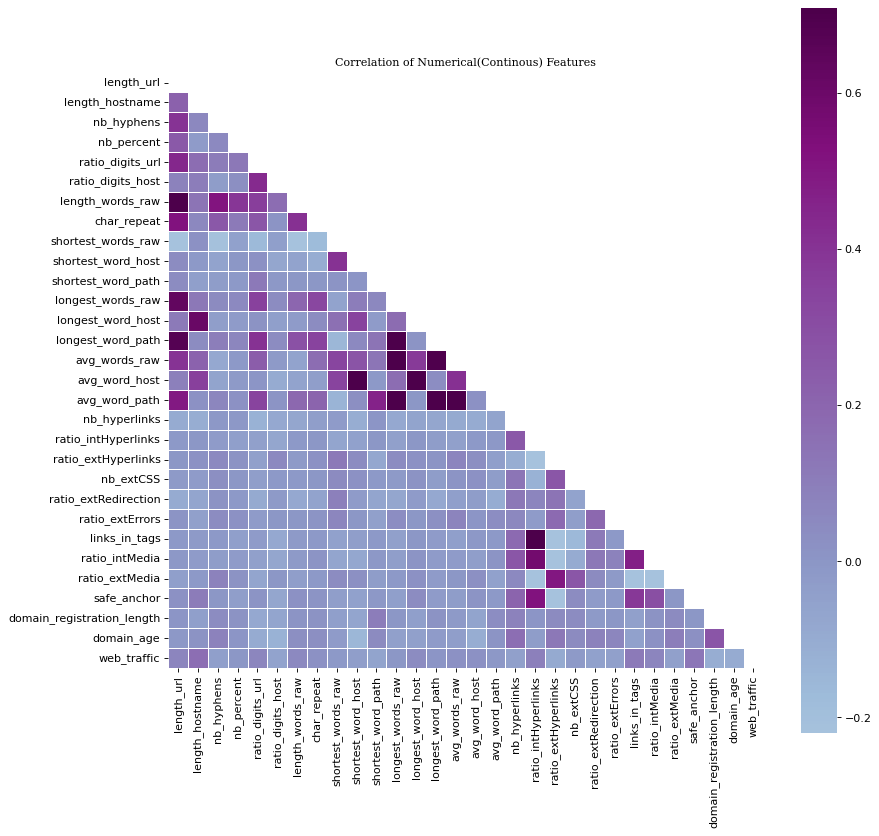

In [80]:
corr = df_data[num_cols].corr()
fig = plt.figure(figsize=(12,12), dpi = 80)
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr,mask=mask,cmap='BuPu', robust=True, center=0,
                            square=True,linewidths=0.5)
plt.title('Correlation of Numerical(Continous) Features', fontsize=15, font= 'Serif')

Text(0, 0.5, 'Average Values')

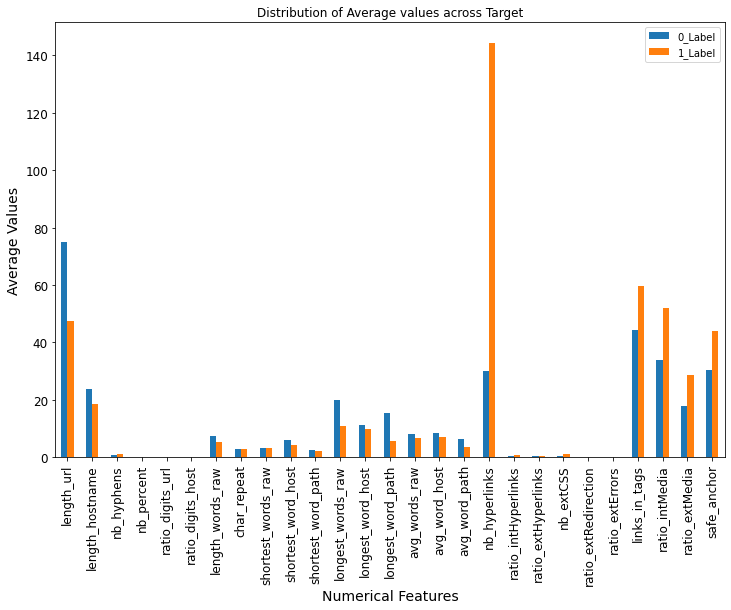

In [81]:
df_distr = df_data.groupby('target')[num_cols].mean().reset_index().T
df_distr.rename(columns={0:'0_Label',1:'1_Label'}, inplace=True)
plt.rcParams['axes.facecolor']='w'
ax = df_distr[1:-3][['0_Label','1_Label']].plot(kind='bar', title ="Distribution of Average values across Target", figsize=(12, 8), legend=True, fontsize=12)
ax.set_xlabel("Numerical Features", fontsize=14)
ax.set_ylabel("Average Values", fontsize=14)

In [82]:
X = df_data.iloc[:,1:-1]
y = df_data.target

train_x,test_x,train_y,test_y =train_test_split(X,y, random_state=42)
print("\n--Training data samples--")
print(train_x.shape)


--Training data samples--
(8572, 87)


In [83]:
scaler = preprocessing.MinMaxScaler()
x_train =scaler.fit_transform(train_x)
x_test = scaler.fit_transform(test_x)
print("Scaled values of Train set \n")
print(x_train)
print("\nScaled values of Test set \n")
print(x_test)

Scaled values of Train set 

[[0.0650706  0.18095238 1.         ... 0.         1.         0.        ]
 [0.04297115 0.06190476 0.         ... 0.         0.         0.6       ]
 [0.07550645 0.06190476 1.         ... 0.         0.         0.5       ]
 ...
 [0.01473297 0.07619048 0.         ... 0.         1.         0.2       ]
 [0.00859423 0.06190476 0.         ... 0.         1.         0.2       ]
 [0.02823818 0.06190476 0.         ... 0.         1.         0.5       ]]

Scaled values of Test set 

[[0.03571429 0.04       0.         ... 0.         0.         0.5       ]
 [0.01461039 0.06285714 0.         ... 0.         0.         0.2       ]
 [0.0487013  0.06285714 0.         ... 0.         0.         1.        ]
 ...
 [0.24350649 0.08571429 0.         ... 0.         1.         0.        ]
 [0.01461039 0.06285714 0.         ... 0.         0.         0.3       ]
 [0.09577922 0.04571429 0.         ... 0.         0.         0.4       ]]


In [84]:
x_tensor =torch.from_numpy(x_train).float()
y_tensor = torch.from_numpy(train_y.values.ravel()).float()
xtest_tensor =  torch.from_numpy(x_test).float()
ytest_tensor =  torch.from_numpy(test_y.values.ravel()).float()

print("\nTrain set Tensors \n")
print(x_tensor)
print(y_tensor)
print("\nTest set Tensors \n")
print(xtest_tensor)
print(ytest_tensor)


Train set Tensors 

tensor([[0.0651, 0.1810, 1.0000,  ..., 0.0000, 1.0000, 0.0000],
        [0.0430, 0.0619, 0.0000,  ..., 0.0000, 0.0000, 0.6000],
        [0.0755, 0.0619, 1.0000,  ..., 0.0000, 0.0000, 0.5000],
        ...,
        [0.0147, 0.0762, 0.0000,  ..., 0.0000, 1.0000, 0.2000],
        [0.0086, 0.0619, 0.0000,  ..., 0.0000, 1.0000, 0.2000],
        [0.0282, 0.0619, 0.0000,  ..., 0.0000, 1.0000, 0.5000]])
tensor([0., 1., 0.,  ..., 0., 0., 1.])

Test set Tensors 

tensor([[0.0357, 0.0400, 0.0000,  ..., 0.0000, 0.0000, 0.5000],
        [0.0146, 0.0629, 0.0000,  ..., 0.0000, 0.0000, 0.2000],
        [0.0487, 0.0629, 0.0000,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.2435, 0.0857, 0.0000,  ..., 0.0000, 1.0000, 0.0000],
        [0.0146, 0.0629, 0.0000,  ..., 0.0000, 0.0000, 0.3000],
        [0.0958, 0.0457, 0.0000,  ..., 0.0000, 0.0000, 0.4000]])
tensor([1., 1., 1.,  ..., 0., 1., 1.])


In [85]:
bs = 64
y_tensor = y_tensor.unsqueeze(1)
train_ds = TensorDataset(x_tensor,y_tensor)
train_dl = DataLoader(train_ds,batch_size=bs)
ytest_tensor = ytest_tensor.unsqueeze(1)
test_ds = TensorDataset(xtest_tensor, ytest_tensor)
test_loader = DataLoader(test_ds, batch_size=32)

In [86]:
y_tensor.shape

torch.Size([8572, 1])

In [90]:
n_input_dim = train_x.shape[1]
n_hidden1 = 300  
n_hidden2 = 100
n_output =  1  
class ChurnModel(nn.Module):
    def __init__(self):
        super(ChurnModel, self).__init__()
        self.layer_1 = nn.Linear(n_input_dim, n_hidden1)
        self.layer_2 = nn.Linear(n_hidden1, n_hidden2)
        self.layer_3 = nn.Linear(n_hidden2, n_output)

        self.relu = nn.ReLU()
        self.sigmoid =nn.Sigmoid()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(n_hidden1)
        self.batchnorm2 = nn.BatchNorm1d(n_hidden2)


    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.sigmoid(self.layer_3(x))
        return x

model = ChurnModel()
model

ChurnModel(
  (layer_1): Linear(in_features=87, out_features=300, bias=True)
  (layer_2): Linear(in_features=300, out_features=100, bias=True)
  (layer_3): Linear(in_features=100, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [91]:
loss_func = nn.BCELoss()
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
epochs = 50


In [92]:
model.train()
train_loss = []
for epoch in range(epochs):
    for xb,yb in train_dl:
        y_pred = model(xb)
        loss = loss_func(y_pred,yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss.append(loss.item())



Text(0.5, 1.0, 'train loss')

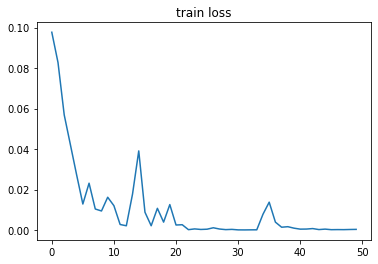

In [93]:
plt.plot(train_loss)
plt.title('train loss')

In [96]:
import itertools

y_pred_list = []

model.eval()
with torch.no_grad():
    for xb_test, yb_test in test_loader:
        y_test_pred = model(xb_test)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.detach().numpy())


y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
ytest_pred = list(itertools.chain.from_iterable(y_pred_list))


In [101]:
y_true_test = test_y.values.ravel()
conf_matrix = confusion_matrix(y_true_test ,ytest_pred)
print("Confusion Matrix of the Test Set")
print("-----------")
print(conf_matrix)

Confusion Matrix of the Test Set
-----------
[[1393   43]
 [ 139 1283]]


In [102]:
print("Precision of the MLP :\t"+str(precision_score(y_true_test,ytest_pred)))
print("Recall of the MLP    :\t"+str(recall_score(y_true_test,ytest_pred)))
print("F1 Score of the Model :\t"+str(f1_score(y_true_test,ytest_pred)))

Precision of the MLP :	0.9675716440422323
Recall of the MLP    :	0.9022503516174403
F1 Score of the Model :	0.9337700145560408
